In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from financepy.utils import *
from financepy.products.rates import *
from financepy.utils.day_count import DayCount, DayCountTypes
import financepy.products.rates.ibor_curve_risk_engine as re
from financepy.market.curves import *
import pickle
from datetime import timedelta

####################################################################
# FINANCEPY BETA Version 0.230 - This build:  03 Mar 2024 at 16:11 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [2]:
# open the pickel file curves.pkl and df_yield.pkl
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)
with open('df_yield.pkl', 'rb') as f:
    df_yield = pickle.load(f)

# change df_yield dtype to np.float32
df_yield = df_yield.astype(np.float32)


## PCA
- use first 6m of yield curve for PCA

Proportion of variance explained by first 3: [0.98860852 0.00720439 0.00357614]


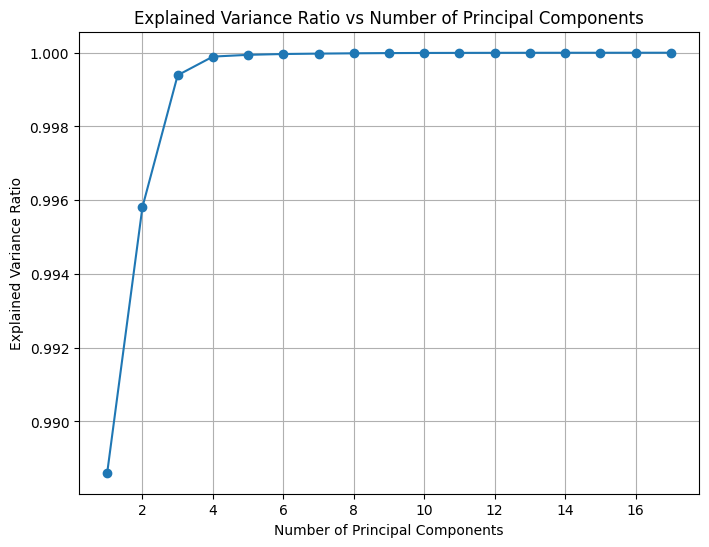

In [3]:
# PCA using numpy
#df_scale = (df_yield - df_yield.mean(axis = 0)) / df_yield.std(axis = 0) # standardize the data
scaler = StandardScaler()
df_scale = scaler.fit_transform(df_yield)
# convert df_scale back to dataframe
df_scale = pd.DataFrame(df_scale, index=df_yield.index, columns=df_yield.columns)
# only use first 6m of data
first_date = df_scale.index[0] # first_date is a string
#first_date = pd.to_datetime(first_date, format='%d-%m-%Y') # convert to datetime object
six_months = timedelta(days=30 * 6) # 6 months in days
# Add 6 months to the original datetime
end_date = first_date + six_months
# convert end_date back to 'dd-mm-yyyy'
dates =  df_yield.index
mask = (dates >= first_date) & (dates <= end_date) # mask for first 6 months
df_scale = df_scale[mask] # only use first 6 months of data

# conduct PCA
cov_matrix = np.cov(df_scale.T)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
explained_variance = eigenvalues / sum(eigenvalues)
explained_variance_ratio = explained_variance.cumsum()
# store the principle components
PC1 = df_scale.dot(eigenvectors[:,0]) # if X=U*Sigma*V^T, then PC1 = X*V[:,0] = U[:,0]*Sigma[0,0]
PC2 = df_scale.dot(eigenvectors[:,1])
PC3 = df_scale.dot(eigenvectors[:,2])

# plot explained variance ratio
print('Proportion of variance explained by first 3:',explained_variance[:3])
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Principal Components')
plt.grid()

the correlation between 1st PC and 10Y yield is: 0.9979911315599547


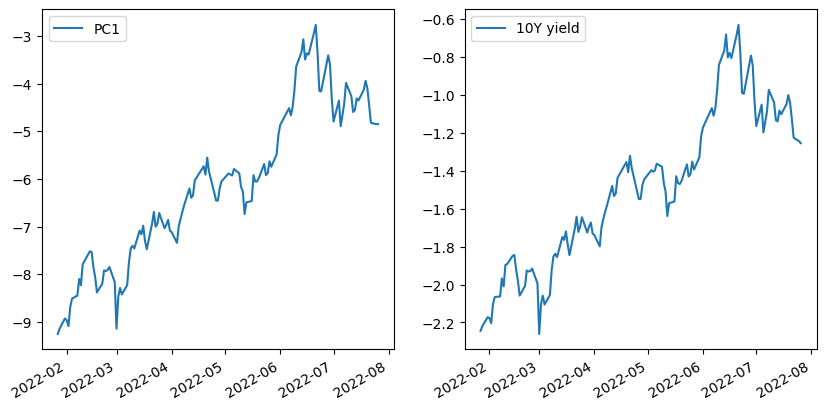

In [4]:
# get the corrlation between 1st PC and level using 10Y
print(f"the correlation between 1st PC and 10Y yield is: {np.corrcoef(PC1, df_scale.loc[:,10])[0][1]}")
# 1nd PC is the level of the curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(dates[mask], PC1, label='PC1')
plt.legend()
plt.subplot(1,2,2)
plt.plot(dates[mask], df_scale.loc[:,10], label='10Y yield')
# make the x-axis date less
plt.gcf().autofmt_xdate()
plt.legend()

the correlation between 2nd PC and 5-10 spread is: -0.49518674393769113


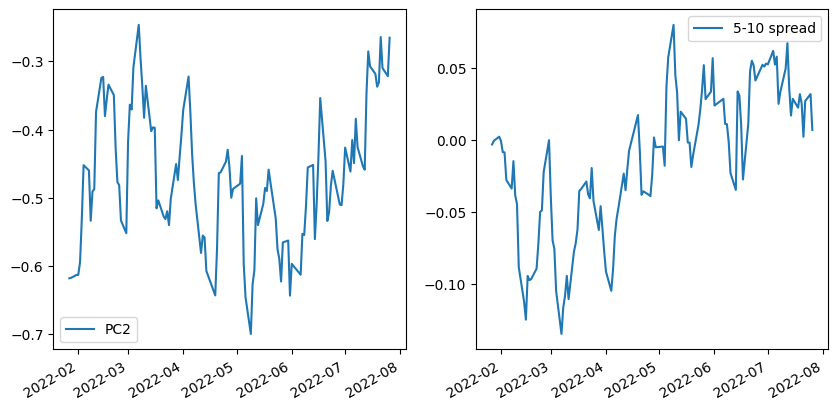

In [5]:
# 2nd PC is the slope of the curve
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(dates[mask],PC3, label='PC2')
plt.legend()
# calculate the slope of the curve
spread_5_10 = df_scale.loc[:,10] - df_scale.loc[:,5] # 10y yield - 5y yield
print(f"the correlation between 2nd PC and 5-10 spread is: {np.corrcoef(PC2, spread_5_10)[0][1]}")
plt.subplot(1,2,2)
plt.plot(dates[mask],spread_5_10, label='5-10 spread')
plt.gcf().autofmt_xdate()
plt.legend()

not strong correlation between the 2nd PC and the slope of curve, which lead us to think that curvature might be more important.

the correlation between 2nd PC and 2s5s10s butterfly is: -0.8536594797967532
the correlation between 2nd PC and 2s10s30s butterfly is: -0.49787428379444176


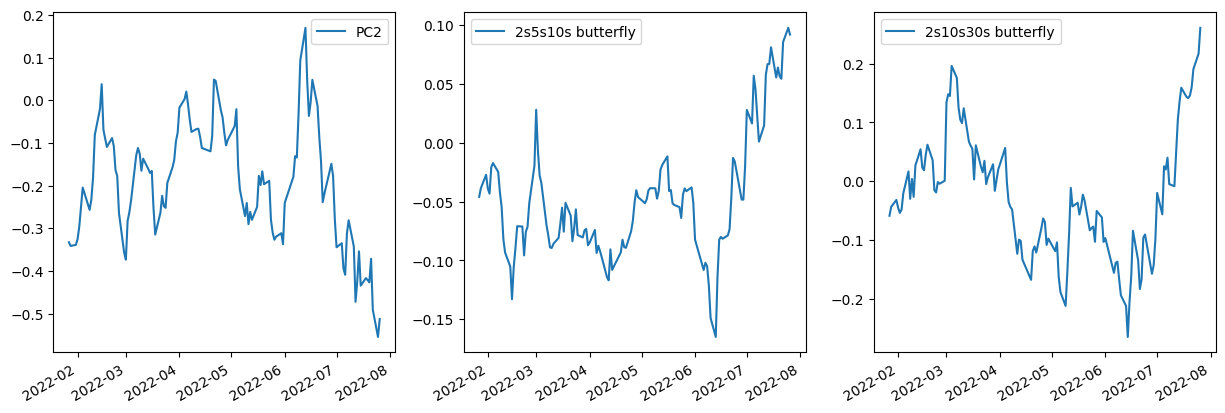

In [6]:
# see correlation between 2nd PC and curvature
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(dates[mask],PC2, label='PC2')
plt.legend()
# calculate the curvature
# 2s5s10s butterfly
curvature1 = df_scale.loc[:,2] - 2*df_scale.loc[:,5] + df_scale.loc[:,10] # 2s5s10s butterfly
# 2s10s30s butterfly
curvature2 = df_scale.loc[:,2] - 2*df_scale.loc[:,10] + df_scale.loc[:,30] # 2s10s30s butterfly
print(f"the correlation between 2nd PC and 2s5s10s butterfly is: {np.corrcoef(PC2, curvature1)[0][1]}")
print(f"the correlation between 2nd PC and 2s10s30s butterfly is: {np.corrcoef(PC2, curvature2)[0][1]}")
plt.subplot(1,3,2)
plt.plot(dates[mask],curvature1, label='2s5s10s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()
plt.subplot(1,3,3)
plt.plot(dates[mask],curvature2, label='2s10s30s butterfly')
plt.gcf().autofmt_xdate()
plt.legend()



We observe a resonable correlation between curvature and PC2

## Contruct Butterfly Trade
- we first use spot swap
- need a function to calculate DV01 of a swap given notional

In [7]:
# some parameters
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
day, month, year = trade_date.day, trade_date.month, trade_date.year
valuation_date = Date(day, month, year)
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.THIRTY_E_360 # 30/360
cal = CalendarTypes.UNITED_KINGDOM # calendar type
curve = curves[trade_date] # curve for trade date

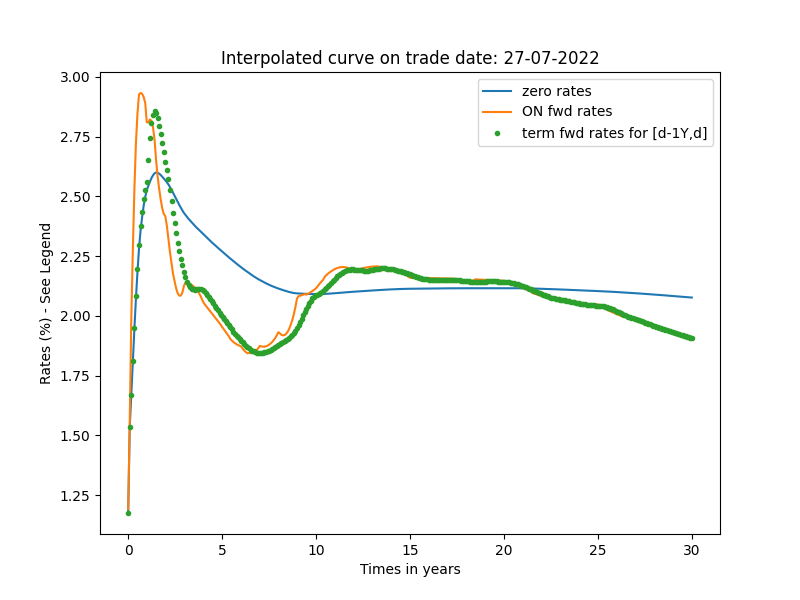

In [8]:
# plot the curve on the day we put on trade
%matplotlib widget
# %matplotlib auto
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years shown in the plot
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

plotCurve(curve, settlement_date, 30, instr_mat_dates_or_tenor = '1Y', title = f'Interpolated curve on trade date: {trade_date.strftime("%d-%m-%Y")}')

We initailize the swap to be ATM so that it allow us to calculate PNL easier once the trade is live.

In [9]:
# ButterFly using spot swaps
# a 2s5s10s butterfly with notionals 1, 2, 1
swap2y = OIS(effective_date=settlement_date, termination_date_or_tenor='2Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional = 10000,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap5y = OIS(effective_date=settlement_date, termination_date_or_tenor='5Y',
                            fixed_leg_type=SwapTypes.RECEIVE, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional = 20000,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

swap10y = OIS(effective_date=settlement_date, termination_date_or_tenor='10Y',
                            fixed_leg_type=SwapTypes.PAY, fixed_coupon=1*gPercent, fixed_freq_type=fixedFreqType, fixed_day_count_type=fixedDCCType, notional = 10000,
                            float_freq_type=floatFreqType, float_day_count_type=floatDCCType, calendar_type=cal)

# set OIS swap to be atm at start
# since there is no set_fixed_rate_to_atm method for OIS, we need to manually create one
# note that if for RECEIVE swap, the swap_rate is negative, but we 
def set_fixed_rate(swap, new_rate: float):
    '''
    Sometimes we need to reset the coupon (fixed rate)
    This function updates caches that depend on it
    '''
    swap._fixed_leg._coupon = new_rate
    swap._fixed_leg.generate_payments()
set_fixed_rate(swap2y, swap2y.swap_rate(settlement_date, curve)) # set 2y swap to be atm
set_fixed_rate(swap5y, -swap5y.swap_rate(settlement_date, curve)) # set 5y swap to be atm, we put a - sign here because the swap_rate is negative
set_fixed_rate(swap10y, swap10y.swap_rate(settlement_date, curve)) # set 10y swap to be atm
fly_spot_2_5_10 = {
    'spot2y': swap2y,
    'spot5y': swap5y,
    'spot10y': swap10y
}

# some facts about the swaps
print("swap rate")
print(swap2y.swap_rate(valuation_date=valuation_date, ois_curve=curve))
print(swap5y.swap_rate(valuation_date=valuation_date, ois_curve=curve))
print(swap10y.swap_rate(valuation_date=valuation_date, ois_curve=curve))
print("value")
# print value
print(swap2y.value(valuation_date, curve))
print(swap5y.value(valuation_date, curve))
print(swap10y.value(valuation_date, curve))
print("pv01")
# print pv01
print(swap2y.pv01(valuation_date, curve))
print(swap5y.pv01(valuation_date, curve))
print(swap10y.pv01(valuation_date, curve))
# 

swap rate
0.026300692875630187
-0.023335228570179965
0.021531730771176733
value
0.0
0.0
-2.2737367544323206e-13
pv01
1.9316254040713619
4.655936809381435
8.870515741021482


In [10]:
# TODO: calculate the ratio for the notional of the butterfly trade such that it is immune to level and slope
def ratio(left, mid, right, valuation_date, curve):
    """
    calculate the ratio for the notional of the butterfly trade such that it is immune to level and slope
    left: OIS object, left wing of the butterfly
    mid: OIS object, middle of the butterfly
    right: OIS object, right wing of the butterfly
    valuation_date: Date object for the date the trade is put on
    curve: OISCURVE object for the curve on the valuation date
    return: np.array, the ratio for the notional of the butterfly trade
    """
    pv01_left = left.pv01(valuation_date, curve)
    pv01_mid = mid.pv01(valuation_date, curve)
    pv01_right = right.pv01(valuation_date, curve)
    # now need notional N_left, N_mid, N_right such that N_left * pv01_left + N_mid * pv01_mid + N_right * pv01_right = 0
    
    return None

#### Now the re.carry_rolldown_report function is not working since we are using a OISCURVE rather than a IBORCURVE, could we rewrite/debug the function so it is consistent with OIS curve? NEED REVISIT

In [11]:
"""
trade_to_use = fly_spot_2_5_10
rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
last_date = fly_spot_2_5_10['spot10y']._maturity_date # last day of the tenor
risk_res = re.carry_rolldown_report( # carry and rolldown report
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = trade_to_use.values(), trade_labels=list(trade_to_use.keys()), )
df_roll = risk_res[1]
"""

"\ntrade_to_use = fly_spot_2_5_10\nrolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report\nlast_date = fly_spot_2_5_10['spot10y']._maturity_date # last day of the tenor\nrisk_res = re.carry_rolldown_report( # carry and rolldown report\n    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, \n    trades = trade_to_use.values(), trade_labels=list(trade_to_use.keys()), )\ndf_roll = risk_res[1]\n"

In [12]:
def plot_metric_for_strategy(curve, strategy, metric = 'DV01'):
    """
    plot metric for a strategy
    Inputs:
    curve: IborSingleCurve
    strategy: dict of IborSwap
    metric: str
    """
    rolldown_tenor = '1Y' # rolldown tenor for carry and rolldown report
    last_date = curve._usedSwaps[-1]._maturity_date
    risk_res = re.carry_rolldown_report(
    curve, grid_last_date = last_date, grid_bucket_tenor = rolldown_tenor, 
    trades = strategy.values(), trade_labels=list(strategy.keys()), )
    df_roll = risk_res[1]

    metric_cols = [c for c in df_roll.columns if c.startswith(metric)]
    nonzero_metric = (df_roll[metric_cols] != 0).any(axis = 1)
    df_metric = df_roll.loc[nonzero_metric]
    df_metric.plot.bar('bucket_label', metric_cols)

    print(df_metric[metric_cols].sum())

"""
#Test (with somewhat convoluted way to just get first 3 outrights)
plot_metric_for_strategy(curve, fly_spot_2_5_10, metric='DV01')
plot_metric_for_strategy(curve, fly_spot_2_5_10, metric='ROLL')
"""

"\n#Test (with somewhat convoluted way to just get first 3 outrights)\nplot_metric_for_strategy(curve, fly_spot_2_5_10, metric='DV01')\nplot_metric_for_strategy(curve, fly_spot_2_5_10, metric='ROLL')\n"

## PNL calculation
- need to come up with a formula to calculate PNL given a swap on a valuation_date and discount_curve, where curve is given per day
- Examples: for day in df_yield.index[trade_day:]
    - calculate the DV01 = PV01 * notional for each swap
    - calculate the coresponding OIS curve yield for each swap

In [13]:
def value(swap,valuation_date,discount_curve,index_curve):
    """
    value a Overnight Index Swap, this is not the same as the Financepy value method as we need index curve as well for floating leg
    swap: OIS object
    valuation_date: Date object for the date we value the swap
    discount_curve: OISCURVE object for the curve we use to discount cashflows
    index_curve: OISCURVE object for the curve we use to get forward rates
    """
    fixed_leg_value = swap._fixed_leg.value(valuation_date, discount_curve)
    float_leg_value = swap._float_leg.value(valuation_date, discount_curve, index_curve)
    return fixed_leg_value + float_leg_value

(array([19174., 19236., 19297., 19358., 19417., 19478., 19539., 19601.,
        19662., 19723., 19783.]),
 [Text(19174.0, 0, '2022-07'),
  Text(19236.0, 0, '2022-09'),
  Text(19297.0, 0, '2022-11'),
  Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03')])

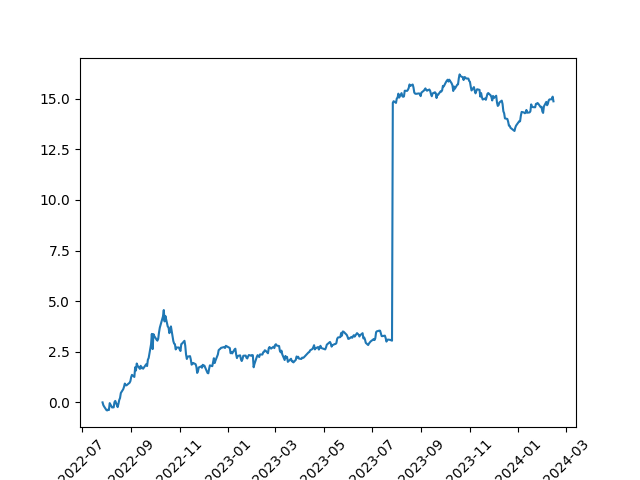

In [14]:
# calculate PNL series (probably need to change the way we calculate pnl)
# the trade date is the first date after 6m
trade_date =  df_yield.index[df_yield.index>end_date][0] # trade from first available date after 6m
post_trade_dates = df_yield.index[df_yield.index >= trade_date]
# initialize a pd series with 0 pnl for each date
trade_to_use = fly_spot_2_5_10
pnl_series = pd.Series(np.zeros(len(post_trade_dates)),index=post_trade_dates)

for date in post_trade_dates:
    day, month, year = date.day, date.month, date.year
    new_valuation_date = Date(day, month, year)
    current_curve = curves[date] # the curve on the date
    for swap in trade_to_use.values():
        # add the pnl for each swap
        pnl_series[date] += value(swap,new_valuation_date,current_curve,curve) - value(swap,valuation_date,curve,curve)
        #print(f"date: {date.strftime('%d-%m-%Y')}, pnl: {pnl_series[date]}")
plt.figure()
plt.plot(pnl_series)
plt.xticks(rotation=45)

the pnl has a jump, there must be something wrong with the way i calculate pnl, need revisit

In [15]:
# correlation between pnl and level
print(f"correlation between pnl and level: {np.corrcoef(pnl_series, df_yield.loc[post_trade_dates,10])[0][1]}")
# correlation between pnl and slope
spread_5_10 = df_yield[10] - df_yield[5] # 10y yield - 5y yield
post_trade_spread = spread_5_10[post_trade_dates]
print(f"correlation between pnl and slope: {np.corrcoef(pnl_series, post_trade_spread)[0][1]}")
# correlation between pnl and curvature
spread_butterfly = df_yield[2] - 2*df_yield[5] + df_yield[10] # 2s5s10s butterfly
post_trade_butterfly = spread_butterfly[post_trade_dates]
print(f"correlation between pnl and curvature: {np.corrcoef(pnl_series, post_trade_butterfly)[0][1]}")

correlation between pnl and level: 0.4976489572296406
correlation between pnl and slope: 0.38470403369941114
correlation between pnl and curvature: 0.6477927039188404
